# Time Series Analysis: Daily Soybean Price

## Importing Necessary Libraries & Loading Data

In [1]:
#pip install pmdarima

In [67]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


from datetime import datetime

import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pmdarima as pm

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Reading in daily soybean prices, exported from Bloomberg Terminal.

In [3]:
daily = pd.read_csv('../Data/S00-USA-csv.csv')
daily.head()

,Date,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume
0,02/18/2020,8.932,8.938,0.000,0.00,8.930,8.932,"210,942.000","106,223.000"
1,02/14/2020,8.927,8.938,-0.025,-0.28,8.927,8.930,"232,144.000","130,575.000"
2,02/13/2020,8.958,8.962,0.037,0.42,8.955,8.960,"250,088.000","193,428.000"
3,02/12/2020,8.920,8.925,0.078,0.88,8.920,8.922,"277,418.000","163,370.000"
4,02/11/2020,8.850,8.847,0.005,0.06,8.850,8.852,"298,204.000","134,299.000"


In [134]:
data = pd.read_csv('../Data/Data_concat.csv')
data.head()

,DATE,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,...,MN_TMIN_lag_1,IA_TMIN_lag_360,IL_TMIN_lag_360,MN_TMIN_lag_360,IA_TMAX_lag_1,IL_TMAX_lag_1,MN_TMAX_lag_1,IA_TMAX_lag_360,IL_TMAX_lag_360,MN_TMAX_lag_360
0,1990-01-02,0.00,0.00,0.0,49.0,45.0,27.0,28.0,25.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-03,0.00,0.00,0.0,45.0,49.0,32.0,35.0,32.0,19.0,...,1.0,NaN,NaN,NaN,49.0,45.0,27.0,NaN,NaN,NaN
2,1990-01-04,0.94,0.05,0.0,42.0,47.0,26.0,21.0,32.0,1.0,...,19.0,NaN,NaN,NaN,45.0,49.0,32.0,NaN,NaN,NaN
3,1990-01-05,0.00,0.00,0.0,40.0,38.0,20.0,18.0,16.0,11.0,...,1.0,NaN,NaN,NaN,42.0,47.0,26.0,NaN,NaN,NaN
4,1990-01-08,0.00,0.00,0.0,43.0,50.0,40.0,31.0,21.0,16.0,...,11.0,NaN,NaN,NaN,40.0,38.0,20.0,NaN,NaN,NaN


In [135]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.sort_index(inplace=True)
data

,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,Settlement Price,...,MN_TMIN_lag_1,IA_TMIN_lag_360,IL_TMIN_lag_360,MN_TMIN_lag_360,IA_TMAX_lag_1,IL_TMAX_lag_1,MN_TMAX_lag_1,IA_TMAX_lag_360,IL_TMAX_lag_360,MN_TMAX_lag_360
DATE,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.00,0.00,0.00,49.0,45.0,27.0,28.0,25.0,1.0,5.613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.00,0.00,0.00,45.0,49.0,32.0,35.0,32.0,19.0,5.673,...,1.0,NaN,NaN,NaN,49.0,45.0,27.0,NaN,NaN,NaN
1990-01-04,0.94,0.05,0.00,42.0,47.0,26.0,21.0,32.0,1.0,5.633,...,19.0,NaN,NaN,NaN,45.0,49.0,32.0,NaN,NaN,NaN
1990-01-05,0.00,0.00,0.00,40.0,38.0,20.0,18.0,16.0,11.0,5.645,...,1.0,NaN,NaN,NaN,42.0,47.0,26.0,NaN,NaN,NaN
1990-01-08,0.00,0.00,0.00,43.0,50.0,40.0,31.0,21.0,16.0,5.707,...,11.0,NaN,NaN,NaN,40.0,38.0,20.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.00,0.00,0.00,53.0,57.0,32.0,27.0,26.0,22.0,9.365,...,19.0,67.0,67.0,62.0,45.0,56.0,35.0,86.0,96.0,68.0
2019-12-26,0.00,0.01,0.01,62.0,68.0,33.0,32.0,46.0,22.0,9.465,...,22.0,62.0,68.0,63.0,53.0,57.0,32.0,78.0,86.0,80.0
2019-12-27,0.00,0.00,0.02,37.0,48.0,25.0,32.0,39.0,20.0,9.415,...,22.0,65.0,60.0,58.0,62.0,68.0,33.0,84.0,89.0,79.0


In [4]:
daily.dtypes

Date                 object
Last                 object
Settlement Price    float64
Change              float64
% Change            float64
Bid                 float64
Ask                 float64
Open Interest        object
Volume               object
dtype: object

Converting the datatype of the Date column to datetime, and setting it as index. I am also sorting the columns by date.

In [5]:
daily['Date'] = pd.to_datetime(daily['Date'])
#daily['Date'] = daily.index 
#pd.to_datetime(daily['Date'])

daily.set_index('Date', inplace=True)

In [6]:
daily.sort_index(inplace=True)
daily.head()

,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume
Date,,,,,,,,
1990-01-02,5.613,5.613,-0.067,-1.19,NaN,NaN,NaN,NaN
1990-01-03,5.673,5.673,0.060,1.07,NaN,NaN,NaN,NaN
1990-01-04,5.633,5.633,-0.040,-0.71,NaN,NaN,NaN,NaN
1990-01-05,5.645,5.645,0.012,0.22,NaN,NaN,NaN,NaN
1990-01-08,5.707,5.707,0.063,1.11,NaN,NaN,NaN,NaN


In [7]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7591 entries, 1990-01-02 to 2020-02-18
Data columns (total 8 columns):
Last                7582 non-null object
Settlement Price    7591 non-null float64
Change              7591 non-null float64
% Change            7591 non-null float64
Bid                 2511 non-null float64
Ask                 2489 non-null float64
Open Interest       4796 non-null object
Volume              4798 non-null object
dtypes: float64(5), object(3)
memory usage: 533.7+ KB


Right now I am only concerned with the "Settlement Price" column, so I will create a new df with just this information.

From Investopedia: "The settlement price is the average price at which a contract trades, calculated at both the open and close of each trading day, and it is important because it determines whether a trader is required to post additional margins."

In [8]:
daily_price = daily[['Settlement Price']]
daily_price

,Settlement Price
Date,
1990-01-02,5.613
1990-01-03,5.673
1990-01-04,5.633
1990-01-05,5.645
1990-01-08,5.707
...,...
2020-02-11,8.847
2020-02-12,8.925
2020-02-13,8.962


In [9]:
daily_price = daily_price[daily_price.index<'2020-01-01']

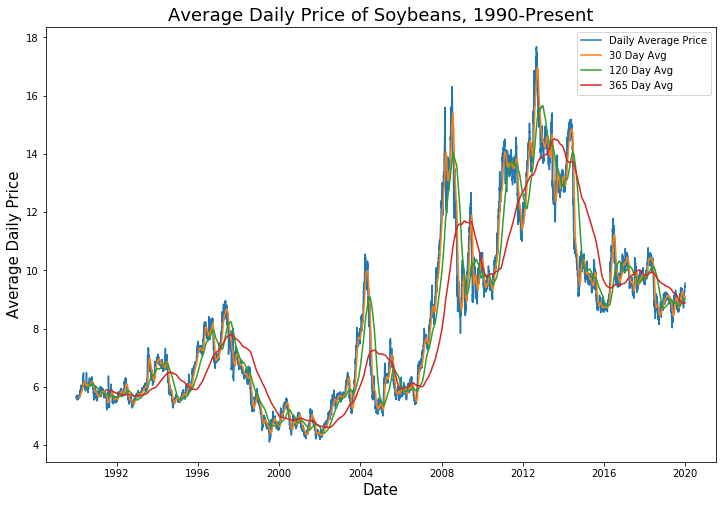

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(daily_price, label='Daily Average Price')
plt.plot(daily_price.rolling(30).mean(), label='30 Day Avg')
plt.plot(daily_price.rolling(120).mean(), label='120 Day Avg')
plt.plot(daily_price.rolling(365).mean(), label='365 Day Avg')
plt.legend()
plt.ylabel('Average Daily Price', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.title('Average Daily Price of Soybeans, 1990-Present', fontsize = 18);

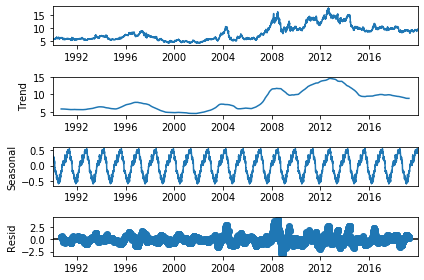

In [93]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(daily_price, period = 360)

# Plot the decomposed time series.
decomp.plot();

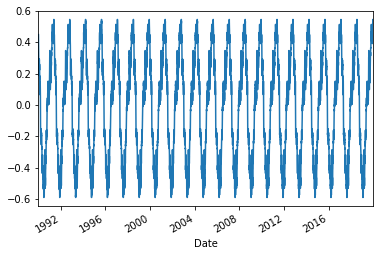

In [99]:
decomp.seasonal.plot()

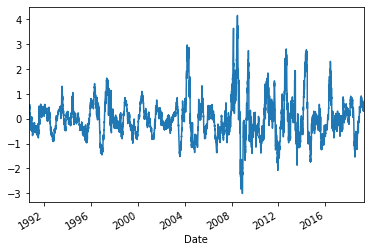

In [98]:
decomp.resid.dropna().plot()

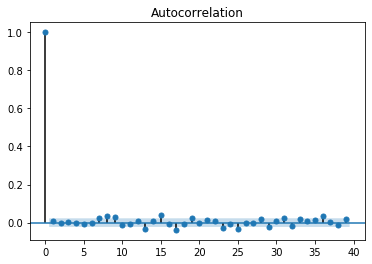

In [89]:
plot_acf(daily_price.diff().dropna());

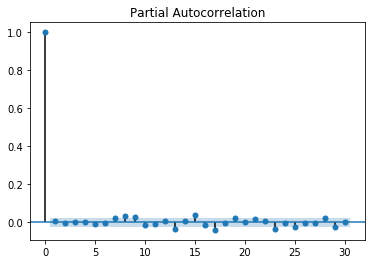

In [90]:
plot_pacf(daily_price.diff().dropna(), lags = 30);

### Dickey-Fuller Test
Using $\alpha$ = 0.05, I will perform the following hypothesis test:  
$H_0$= not stationary  
$H_A$ = stationary

In [15]:
# Dickey-Fuller Test
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [16]:
interpret_dftest(adfuller(daily_price['Settlement Price']))

Test Statistic   -2.26793
p-value           0.18252
dtype: float64

Since $\alpha$ < p-value = 0.18, we cannot reject the null hypothesis. So, I will take the difference and perform the test again.

In [17]:
interpret_dftest(adfuller(daily_price['Settlement Price'].diff(1).dropna()))

Test Statistic   -1.363389e+01
p-value           1.702822e-25
dtype: float64

Since $\alpha$ > p-value, we can reject the null hypothesis and accept the alternative hypothesis that the data is stationary. We can now model our time series data.

## Modeling

I am dividing my data into training data and testing data, with my training data consisting of data from 1990 through 2016 and my testing data consisting of data from 2017, 2018, 2019.  I will use my training data to "train" my model, and evaluate it based on the mean absolute error between by test data (actual) and my predictions for that same date range using my model.

In [18]:
#rows_train = round(0.75*len(daily_price))
#rows_test = len(daily_price) - rows_train

In [19]:
#daily_price['SPdiff_1']= daily_price['Settlement Price'].diff(1)

In [20]:
train = daily_price[daily_price.index<'2017-01-01']

In [21]:
test = daily_price[daily_price.index>='2017-01-01']

In [22]:
#train = daily_price['Settlement Price'].head(rows_train)
#test = daily_price['Settlement Price'].tail(rows_test)

In [23]:
#train.dropna(inplace=True)
#train = train[train.index] 

Gridsearching for best values of p and q.

In [91]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
# Use nested for loop to iterate over values of p and q.
for p in range(10):
    for q in range(10):
        # Insert try and except statements.
        try:
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q}) model.')
            # Instantiate ARIMA model.
            arima = ARIMA(endog = train.astype(float).dropna(), # endog = Y variable
                          order = (p, 1, q))
            # Fit ARIMA model.
            model = arima.fit()
            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0) model.
The AIC for ARIMA(0,1,0) is: -7380.874614412662
Attempting to fit ARIMA(0, 1, 1) model.
The AIC for ARIMA(0,1,1) is: -7379.563696014899
Attempting to fit ARIMA(0, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(0,1,2) is: -7377.637231125267
Attempting to fit ARIMA(0, 1, 3) model.
The AIC for ARIMA(0,1,3) is: -7375.664162086763
Attempting to fit ARIMA(0, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(0,1,4) is: -7373.667847666518
Attempting to fit ARIMA(0, 1, 5) model.
The AIC for ARIMA(0,1,5) is: -7372.3317246919105
Attempting to fit ARIMA(0, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(0,1,6) is: -7370.486982469243
Attempting to fit ARIMA(0, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(0,1,7) is: -7372.684773832556
Attempting to fit ARIMA(0, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(0,1,8) is: -7380.64121539595
Attempting to fit ARIMA(0, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(0,1,9) is: -7385.1828091312855
Attempting to fit ARIMA(1, 1, 0) model.
The AIC for ARIMA(1,1,0) is: -7379.559119601177
Attempting to fit ARIMA(1, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(1,1,1) is: -7377.644518575111
Attempting to fit ARIMA(1, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,2) is: -7375.6476979916915
Attempting to fit ARIMA(1, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,3) is: -7373.664525493128
Attempting to fit ARIMA(1, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,4) is: -7371.717086781729
Attempting to fit ARIMA(1, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,5) is: -7370.355267722502
Attempting to fit ARIMA(1, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,6) is: -7368.902049464148
Attempting to fit ARIMA(1, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,7) is: -7379.429758636477
Attempting to fit ARIMA(1, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,8) is: -7382.400852572802
Attempting to fit ARIMA(1, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,9) is: -7383.297948970838
Attempting to fit ARIMA(2, 1, 0) model.
The AIC for ARIMA(2,1,0) is: -7377.635477143285
Attempting to fit ARIMA(2, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(2,1,1) is: -7375.647796336583
Attempting to fit ARIMA(2, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,2) is: -7398.312152647319
Attempting to fit ARIMA(2, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,3) is: -7385.420644169346
Attempting to fit ARIMA(2, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,4) is: -7384.212733974877
Attempting to fit ARIMA(2, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,5) is: -7382.170006981105
Attempting to fit ARIMA(2, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,6) is: -7381.928704256894
Attempting to fit ARIMA(2, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,7) is: -7393.288188910483
Attempting to fit ARIMA(2, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,8) is: -7392.374721336288
Attempting to fit ARIMA(2, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,9) is: -7381.703487996387
Attempting to fit ARIMA(3, 1, 0) model.
The AIC for ARIMA(3,1,0) is: -7375.666228479557
Attempting to fit ARIMA(3, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(3,1,1) is: -7373.666502165503
Attempting to fit ARIMA(3, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,2) is: -7385.496505370789
Attempting to fit ARIMA(3, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. 

The AIC for ARIMA(3,1,3) is: -7389.832861057646
Attempting to fit ARIMA(3, 1, 4) model.
The AIC for ARIMA(3,1,4) is: -7382.242369119722
Attempting to fit ARIMA(3, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,5) is: -7391.552545638991
Attempting to fit ARIMA(3, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,6) is: -7394.283532116118
Attempting to fit ARIMA(3, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,7) is: -7393.967176633101
Attempting to fit ARIMA(3, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,8) is: -7392.538293000587
Attempting to fit ARIMA(3, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,9) is: -7390.069486679979
Attempting to fit ARIMA(4, 1, 0) model.
The AIC for ARIMA(4,1,0) is: -7373.669051072855
Attempting to fit ARIMA(4, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(4,1,1) is: -7371.7197881718785
Attempting to fit ARIMA(4, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,2) is: -7384.2112218859875
Attempting to fit ARIMA(4, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,3) is: -7382.243832598186
Attempting to fit ARIMA(4, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,4) is: -7419.074603645422
Attempting to fit ARIMA(4, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,5) is: -7417.4031961568035
Attempting to fit ARIMA(4, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,6) is: -7393.20596671374
Attempting to fit ARIMA(4, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,7) is: -7392.857634722095
Attempting to fit ARIMA(4, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,8) is: -7392.749568025254
Attempting to fit ARIMA(4, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,9) is: -7402.021360742165
Attempting to fit ARIMA(5, 1, 0) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,0) is: -7372.324632080326
Attempting to fit ARIMA(5, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,1) is: -7370.340347332032
Attempting to fit ARIMA(5, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,2) is: -7382.2120791876005
Attempting to fit ARIMA(5, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,3) is: -7391.762618733519
Attempting to fit ARIMA(5, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,4) is: -7404.928681037232
Attempting to fit ARIMA(5, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,5) is: -7401.556475223817
Attempting to fit ARIMA(5, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,6) is: -7391.447513661176
Attempting to fit ARIMA(5, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,7) is: -7400.722826915233
Attempting to fit ARIMA(5, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,8) is: -7388.373195721208
Attempting to fit ARIMA(5, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(5,1,9) is: -7400.023668501068
Attempting to fit ARIMA(6, 1, 0) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,0) is: -7370.43011216382
Attempting to fit ARIMA(6, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,1) is: -7368.833742711013
Attempting to fit ARIMA(6, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,2) is: -7381.9893662542745
Attempting to fit ARIMA(6, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,3) is: -7394.263445334418
Attempting to fit ARIMA(6, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/andreayoss/anacond

The AIC for ARIMA(6,1,4) is: -7401.830922733621
Attempting to fit ARIMA(6, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,5) is: -7391.557728690026
Attempting to fit ARIMA(6, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,6) is: -7415.759324673636
Attempting to fit ARIMA(6, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,7) is: -7402.219743436839
Attempting to fit ARIMA(6, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,8) is: -7397.50001207041
Attempting to fit ARIMA(6, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(6,1,9) is: -7403.410552733694
Attempting to fit ARIMA(7, 1, 0) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(7,1,0) is: -7372.929837388347
Attempting to fit ARIMA(7, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(7,1,1) is: -7379.986128310848
Attempting to fit ARIMA(7, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(7,1,2) is: -7393.121680704295
Attempting to fit ARIMA(7, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(7,1,3) is: -7393.6120443461405
Attempting to fit ARIMA(7, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(7,1,4) is: -7392.8719542412255
Attempting to fit ARIMA(7, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(7,1,5) is: -7400.564885884196
Attempting to fit ARIMA(7, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(7,1,6) is: -7402.100754792034
Attempting to fit ARIMA(7, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

The AIC for ARIMA(7,1,7) is: -7400.457144629661
Attempting to fit ARIMA(7, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(7,1,8) is: -7398.099184358325
Attempting to fit ARIMA(7, 1, 9) model.
The AIC for ARIMA(7,1,9) is: -7409.711562010474
Attempting to fit ARIMA(8, 1, 0) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(8,1,0) is: -7382.084954659553
Attempting to fit ARIMA(8, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(8,1,1) is: -7382.854479166195
Attempting to fit ARIMA(8, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(8,1,2) is: -7391.853928163866
Attempting to fit ARIMA(8, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(8,1,3) is: -7392.247499387817
Attempting to fit ARIMA(8, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(8,1,4) is: -7392.370087019695
Attempting to fit ARIMA(8, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(8,1,5) is: -7388.003258750694
Attempting to fit ARIMA(8, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(8,1,6) is: -7397.324328781448
Attempting to fit ARIMA(8, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/

The AIC for ARIMA(8,1,7) is: -7399.320986064529
Attempting to fit ARIMA(8, 1, 8) model.
Attempting to fit ARIMA(8, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Attempting to fit ARIMA(9, 1, 0) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(9,1,0) is: -7384.768924022661
Attempting to fit ARIMA(9, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(9,1,1) is: -7382.965683240716
Attempting to fit ARIMA(9, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(9,1,2) is: -7394.751626154386
Attempting to fit ARIMA(9, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Attempting to fit ARIMA(9, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(9,1,4) is: -7393.209316226785
Attempting to fit ARIMA(9, 1, 5) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(9,1,5) is: -7402.764642337028
Attempting to fit ARIMA(9, 1, 6) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Attempting to fit ARIMA(9, 1, 7) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Attempting to fit ARIMA(9, 1, 8) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Attempting to fit ARIMA(9, 1, 9) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)




MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,1,4).
This model has an AIC of -7419.074603645422.


The model that minimizes AIC on the training data has p=2 and q=3, so I will run the ARIMA(4,1,4) model.

4,1,4 = -7419.07

In [106]:
model = ARIMA(endog = train.astype(float).dropna(),
              order = (4,1,4))
arima = model.fit()

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [101]:
test

,Settlement Price
Date,
2017-01-03,9.950
2017-01-04,10.153
2017-01-05,10.125
2017-01-06,9.948
2017-01-09,10.052
...,...
2019-12-24,9.365
2019-12-26,9.465
2019-12-27,9.415


In [104]:
preds = model.predict(start = test.index[1], 
                        end = test.index[-1])
preds

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

In [107]:
forecast, stderr, conf_int = arima.forecast(len(test), alpha = 0.05)

In [108]:
print(f'MAE = {mean_absolute_error(test, forecast)}')

MAE = 0.9780106543961353


In [109]:
resid = test['Settlement Price']-forecast

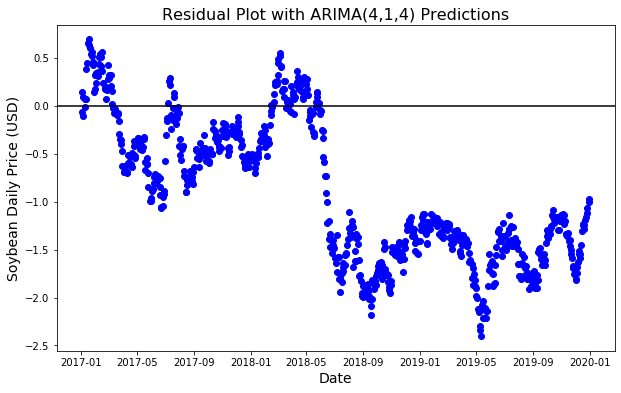

In [110]:
plt.figure(figsize=(10,6))
plt.plot(resid, 'bo', color = 'blue') #line
plt.ylabel('Soybean Daily Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title(label = 'Residual Plot with ARIMA(4,1,4) Predictions', fontsize=16) 
plt.axhline(0, color = 'k', ls = '-')
plt.show();

Text(0.5, 1.0, 'Daily Average Soybean Price with ARIMA(4, 1, 4) Predictions')

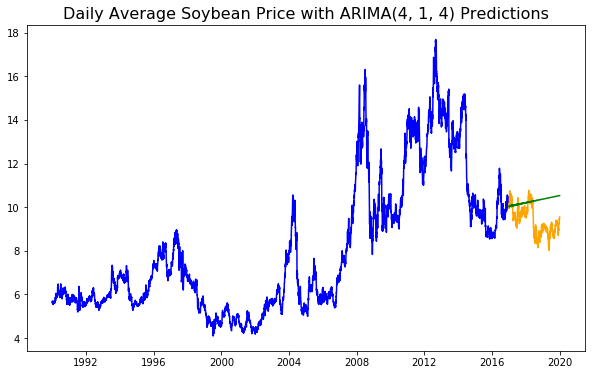

In [111]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, train['Settlement Price'], color = 'blue', label = 'Training Prices')

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot predicted test values.
plt.plot(test.index, forecast, color = 'green', label = 'ARIMA Predictions')

plt.title(label = 'Daily Average Soybean Price with ARIMA(4, 1, 4) Predictions', fontsize=16)

Note that our model expects the price to increase with inflation. However, in June 2018, there was speculation of a trade war between the US and China, one of the US's largest soybean customers, and so the market quickly responded to this potential drop in demand with a price drop.  A month later, in July 2018, this speculation was confirmed as China imposed a 25% import tariff on US Soybeans. 

In [112]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.Settlement Price   No. Observations:                 6804
Model:                 ARIMA(4, 1, 4)   Log Likelihood                3719.537
Method:                       css-mle   S.D. of innovations              0.140
Date:                Sun, 08 Mar 2020   AIC                          -7419.075
Time:                        20:58:56   BIC                          -7350.822
Sample:                             1   HQIC                         -7395.522
                                                                              
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0007      0.002      0.385      0.700      -0.003       0.004
ar.L1.D.Settlement Price     0.2747      0.008     35.828      0.000       0.260       0.290
ar.L2.D.Settlement Price    -0.8003      0.011    -72.988      0.000      -0.822      -0.779
ar.L3.D.Settlement Price     0.2696      0.011     24.440      0.000       0.248       0.291
ar.L4.D.Settlement Price    -0.9791      0.008   -119.676      0.000      -0.995      -0.963
ma.L1.D.Settlement Price    -0.2718      0.010    -27.009      0.000      -0.292      -0.252
ma.L2.D.Settlement Price     0.7980      0.015     53.629      0.000       0.769       0.827
ma.L3.D.Settlement Price    -0.2627      0.015    -17.421      0.000      -0.292      -0.233
ma.L4.D.Settlement Price     0.9622      0.011     85.036      0.000       0.940       0.984
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4841           -0.8817j            1.0058           -0.3299
AR.2           -0.4841           +0.8817j            1.0058            0.3299
AR.3            0.6217           -0.7893j            1.0048           -0.1438
AR.4            0.6217           +0.7893j            1.0048            0.1438
MA.1           -0.4859           -0.8861j            1.0106           -0.3298
MA.2           -0.4859           +0.8861j            1.0106            0.3298
MA.3            0.6224           -0.7939j            1.0087           -0.1442
MA.4            0.6224           +0.7939j            1.0087            0.1442
-----------------------------------------------------------------------------
"""

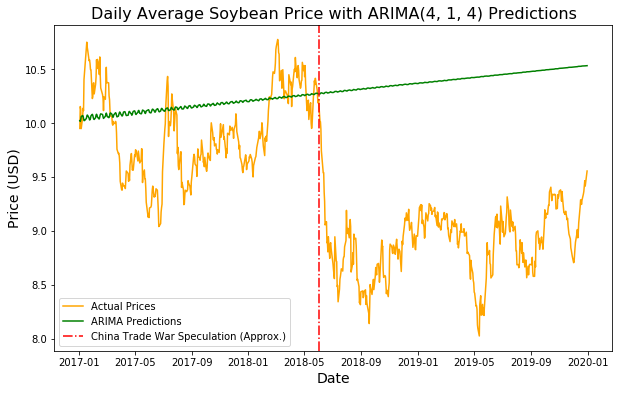

In [113]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot predicted test values.
plt.plot(test.index, forecast, color = 'green', label = 'ARIMA Predictions')

# Plot Approx China Trade War Speculation  
plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'Daily Average Soybean Price with ARIMA(4, 1, 4) Predictions', fontsize=16);

# Fit auto ARIMA; modified code from Boom's Supplemental ARIMA exercises
fitted_arima = pm.auto_arima(
    y = train,                # specify time series data source
    start_p = 1,            # gridsearch p starting from 1
    max_p = 5,              # gridsearch p ending at 5
    start_q = 1,            # gridsearch q starting from 1
    max_q = 5,              # gridsearch q ending at 5
    d = 1,                 
    m=365,
    seasonal=True,
    D=0,
    trace=True,
    #error_action='ignore',  # don't want to know if an order does not work
    #suppress_warnings=True,
    #stepwise=True
)

order = fitted_arima.order
order

# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_P = 0
best_Q = 0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        for P in range(5):
            for Q in range(5):
        # Insert try and except statements.
                try:
                    
                    print(f'Attempting to fit SARIMA({p}, 1, {q}) model with seasonal ({P},1,{Q},30).')
                    # Instantiate SARIMA model.
                    sarima = sm.tsa.statespace.SARIMAX(endog = train.astype(float).dropna(),
                                                       order = (p,1,q), 
                                                       seasonal_order = (P,1,Q,30))

                    # Fit SARIMA model.
                    model = sarima.fit()


                    print(f'The AIC for SARIMA({p},1,{q})*({P},1,{Q},30) is: {model.aic}')

                    # Is my current model's AIC better than our best_aic?
                    if model.aic < best_aic:
                        # If so, let's overwrite best_aic, best_p, and best_q.
                        best_aic = model.aic
                        best_p = p
                        best_q = q
                        best_P = P
                        best_Q = Q
                except:
                    pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the SARIMA({best_p},1,{best_q})*({best_P},1,{best_Q},30).')
print(f'This model has an AIC of {best_aic}.')

smodel.order

In [63]:
daily[daily.index<'2020-01-01']

,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,Volume
Date,,,,,,,,
1990-01-02,5.613,5.613,-0.067,-1.19,NaN,NaN,NaN,NaN
1990-01-03,5.673,5.673,0.060,1.07,NaN,NaN,NaN,NaN
1990-01-04,5.633,5.633,-0.040,-0.71,NaN,NaN,NaN,NaN
1990-01-05,5.645,5.645,0.012,0.22,NaN,NaN,NaN,NaN
1990-01-08,5.707,5.707,0.063,1.11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-12-24,9.370,9.365,0.025,0.27,9.365,9.375,"91,109.000","45,245.000"
2019-12-26,9.460,9.465,0.100,1.07,9.460,9.460,"334,995.000","55,766.000"
2019-12-27,9.422,9.415,-0.050,-0.53,9.420,9.422,"340,301.000","106,606.000"


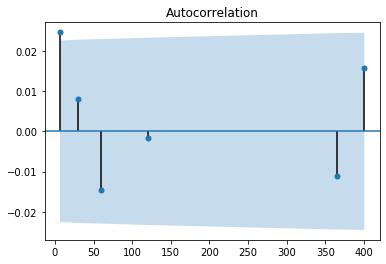

In [119]:
plot_acf(daily_price.diff().dropna(), lags = [7, 30, 60, 120, 365, 400]);

In [34]:
model_sm = sm.tsa.statespace.SARIMAX(endog = train.astype(float).dropna(),
                                     order = (4,1,4), 
                                     seasonal_order = (0,0,0,365))
sarimax = model_sm.fit()

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [35]:
forecast_sm = sarimax.forecast(len(test), step=1, alpha = 0.05)

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [36]:
forecast

array([10.02215041, 10.01510755, 10.03338596, 10.05972781, 10.06936883,
       10.06421376, 10.04574082, 10.02305302, 10.02222927, 10.04168221,
       10.06111102, 10.07432683, 10.06991378, 10.04576993, 10.02866293,
       10.03061075, 10.04410324, 10.06673363, 10.08088211, 10.0698423 ,
       10.04983074, 10.03627917, 10.03319679, 10.05006446, 10.07456034,
       10.08168267, 10.07305484, 10.05652726, 10.03828163, 10.03865122,
       10.05880161, 10.07675982, 10.08498565, 10.0793983 , 10.05784604,
       10.04248546, 10.04740822, 10.06216881, 10.08069996, 10.09179947,
       10.08063175, 10.06067841, 10.05043692, 10.05116818, 10.06657534,
       10.08845325, 10.09381237, 10.08266754, 10.06758384, 10.05383729,
       10.05533514, 10.07504854, 10.09178292, 10.09592124, 10.08896787,
       10.0704096 , 10.05706108, 10.06377442, 10.0795613 , 10.09455231,
       10.10237053, 10.09165811, 10.07249661, 10.06468994, 10.06879193,
       10.08294417, 10.10166074, 10.10568046, 10.093059  , 10.07

In [37]:
print(f'MAE = {mean_absolute_error(test, forecast_sm)}')

MAE = 0.7709069479848628


In [38]:
forecast_sm.index = test.index

In [39]:
resid_sm = test['Settlement Price']-forecast_sm
resid_sm

Date
2017-01-03   -0.075349
2017-01-04    0.129794
2017-01-05    0.093680
2017-01-06   -0.097313
2017-01-09   -0.000627
                ...   
2019-12-24   -0.673370
2019-12-26   -0.573370
2019-12-27   -0.623370
2019-12-30   -0.513370
2019-12-31   -0.483370
Length: 754, dtype: float64

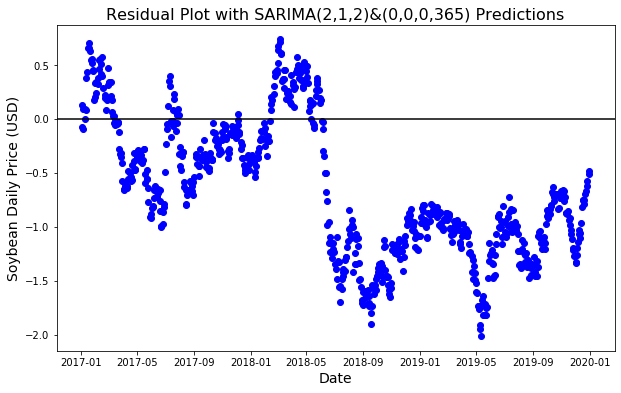

In [40]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(resid_sm, 'bo', color = 'blue')
plt.ylabel('Soybean Daily Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title(label = 'Residual Plot with SARIMA(2,1,2)&(0,0,0,365) Predictions', fontsize=16)
plt.axhline(0, color = 'k', ls = '-')
plt.show();

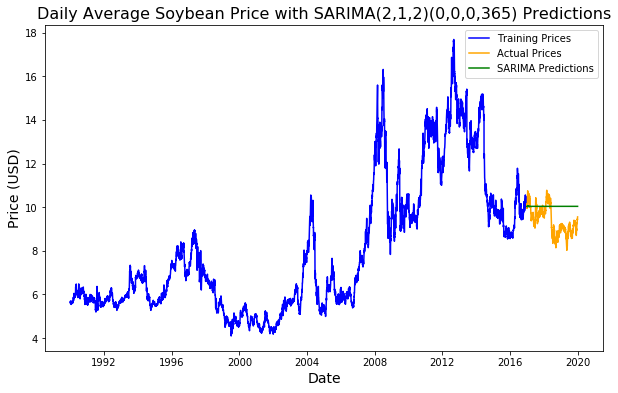

In [41]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, pd.DataFrame(train), color = 'blue', label = 'Training Prices')

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot predicted test values.
plt.plot(test.index, forecast_sm, color = 'green', label = 'SARIMA Predictions')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'Daily Average Soybean Price with SARIMA(2,1,2)(0,0,0,365) Predictions', fontsize=16);

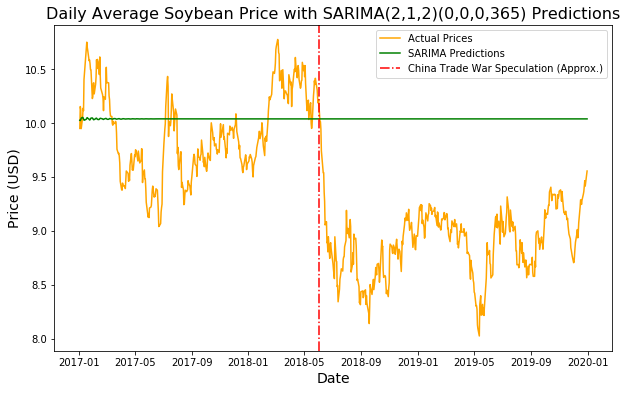

In [42]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot predicted test values.
plt.plot(test.index, forecast_sm, color = 'green', label = 'SARIMA Predictions')

# Plot Approx China Trade War Speculation  
plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'Daily Average Soybean Price with SARIMA(2,1,2)(0,0,0,365) Predictions', fontsize=16);

In [43]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Settlement Price   No. Observations:                 6805
Model:               SARIMAX(4, 1, 4)   Log Likelihood                3703.447
Date:                Sun, 08 Mar 2020   AIC                          -7388.893
Time:                        18:19:11   BIC                          -7327.466
Sample:                             0   HQIC                         -7367.696
                               - 6805                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4365      0.536      0.815      0.415      -0.613       1.486
ar.L2         -0.2561      0.460     -0.557      0.577      -1.157       0.645
ar.L3         -0.4904      0.451     -1.087      0.277      -1.374       0.394
ar.L4         -0.1524      0.502     -0.304      0.761      -1.136       0.831
ma.L1         -0.4260      0.537     -0.793      0.428      -1.479       0.627
ma.L2          0.2575      0.455      0.566      0.572      -0.635       1.150
ma.L3          0.4961      0.445      1.114      0.265      -0.377       1.369
ma.L4          0.1356      0.500      0.271      0.786      -0.844       1.115
sigma2         0.0197   9.47e-05    208.053      0.000       0.020       0.020
===================================================================================
Ljung-Box (Q):                       90.94   Jarque-Bera (JB):            179665.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.20   Skew:                            -1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

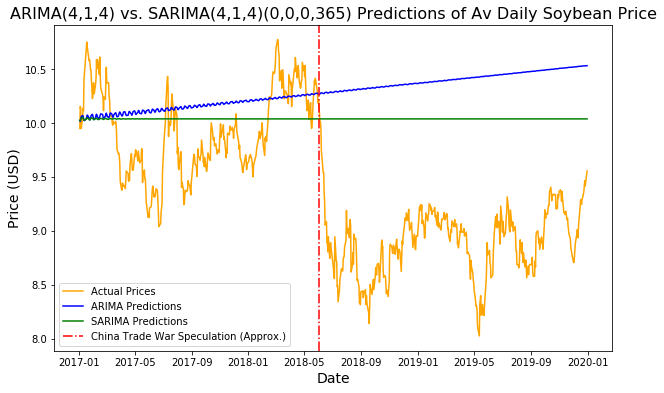

In [44]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')


# Plot ARIMA predicted test values.
plt.plot(test.index, forecast, color = 'blue', label = 'ARIMA Predictions')

# Plot SARIMA predicted test values.
plt.plot(test.index, forecast_sm, color = 'green', label = 'SARIMA Predictions')

# Plot Approx China Trade War Speculation  
plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'ARIMA(4,1,4) vs. SARIMA(4,1,4)(0,0,0,365) Predictions of Av Daily Soybean Price', fontsize=16);

TRIAL WITH ONE YEAR OUT

In [45]:
train_trial = daily_price[daily_price.index<'2016-01-01']
test_trial = daily_price[daily_price.index>='2017-01-01']

In [193]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        # Insert try and except statements.
        try:
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q}) model.')
            # Instantiate ARIMA model.
            arima = ARIMA(endog = train_trial.astype(float).dropna(), # endog = Y variable
                          order = (p, 1, q))
            # Fit ARIMA model.
            model = arima.fit()
            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0) model.
The AIC for ARIMA(0,1,0) is: -7114.697983845685
Attempting to fit ARIMA(0, 1, 1) model.
The AIC for ARIMA(0,1,1) is: -7113.678861911678
Attempting to fit ARIMA(0, 1, 2) model.
The AIC for ARIMA(0,1,2) is: -7111.851525922004
Attempting to fit ARIMA(0, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(0,1,3) is: -7109.912290184893
Attempting to fit ARIMA(0, 1, 4) model.
The AIC for ARIMA(0,1,4) is: -7108.077431217116
Attempting to fit ARIMA(1, 1, 0) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(1,1,0) is: -7113.668664951823
Attempting to fit ARIMA(1, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,1) is: -7111.845325898841
Attempting to fit ARIMA(1, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,2) is: -7109.868724144777
Attempting to fit ARIMA(1, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,3) is: -7109.378689801499
Attempting to fit ARIMA(1, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(1,1,4) is: -7106.177357529643
Attempting to fit ARIMA(2, 1, 0) model.
The AIC for ARIMA(2,1,0) is: -7111.84805026076
Attempting to fit ARIMA(2, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(2,1,1) is: -7109.869799889486
Attempting to fit ARIMA(2, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,2) is: -7134.418601194913
Attempting to fit ARIMA(2, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,3) is: -7120.023197773597
Attempting to fit ARIMA(2, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(2,1,4) is: -7118.157515981249
Attempting to fit ARIMA(3, 1, 0) model.
The AIC for ARIMA(3,1,0) is: -7109.922315190968
Attempting to fit ARIMA(3, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(3,1,1) is: -7109.378292701687
Attempting to fit ARIMA(3, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,2) is: -7121.714560113509
Attempting to fit ARIMA(3, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,3) is: -7117.7021332445365
Attempting to fit ARIMA(3, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(3,1,4) is: -7116.854796354619
Attempting to fit ARIMA(4, 1, 0) model.
The AIC for ARIMA(4,1,0) is: -7108.092869870463
Attempting to fit ARIMA(4, 1, 1) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

The AIC for ARIMA(4,1,1) is: -7106.198760769137
Attempting to fit ARIMA(4, 1, 2) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,2) is: -7118.437115177738
Attempting to fit ARIMA(4, 1, 3) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,3) is: -7117.16890118939
Attempting to fit ARIMA(4, 1, 4) model.


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for ARIMA(4,1,4) is: -7120.20053976975


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,2).
This model has an AIC of -7134.418601194913.


In [46]:
model_trial = ARIMA(endog = train_trial.astype(float).dropna(),order = (2,1,2))
arima_trial = model_trial.fit()

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [47]:
forecast_trial, stderr_trial, conf_int_trial = arima_trial.forecast(len(test_trial), alpha = 0.05)

In [48]:
print(f'MAE = {mean_absolute_error(test, forecast_trial)}')

MAE = 0.6906150089145122


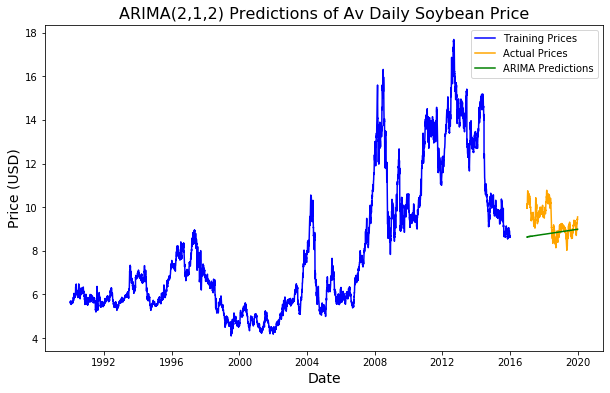

In [49]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train_trial.index, train_trial['Settlement Price'], color = 'blue', label = 'Training Prices')

# Plot testing data.
plt.plot(test_trial.index, test_trial['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot ARIMA predicted test values.
plt.plot(test_trial.index, forecast_trial, color = 'g', label = 'ARIMA Predictions')

# Plot SARIMA predicted test values.
#plt.plot(test.index, forecast_sm, color = 'green', label = 'SARIMA Predictions')

# Plot Approx China Trade War Speculation  
#plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'ARIMA(2,1,2) Predictions of Av Daily Soybean Price', fontsize=16);

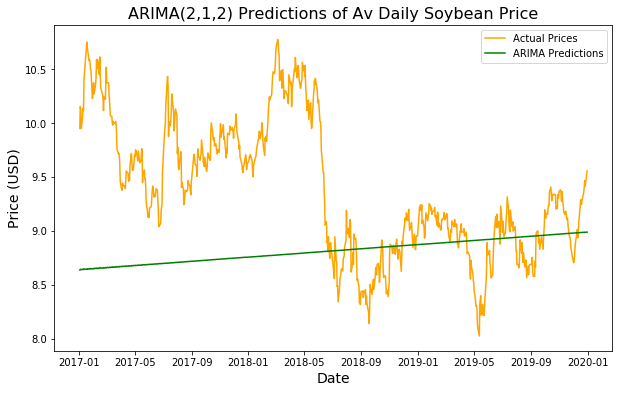

In [50]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
#plt.plot(train_trial.index, train_trial['Settlement Price'], color = 'blue', label = 'Training Prices')

# Plot testing data.
plt.plot(test_trial.index, test_trial['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot ARIMA predicted test values.
plt.plot(test_trial.index, forecast_trial, color = 'g', label = 'ARIMA Predictions')

# Plot SARIMA predicted test values.
#plt.plot(test.index, forecast_sm, color = 'green', label = 'SARIMA Predictions')

# Plot Approx China Trade War Speculation  
#plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'ARIMA(2,1,2) Predictions of Av Daily Soybean Price', fontsize=16);

In [51]:
resid_trial = test_trial['Settlement Price']-forecast_trial
resid_trial

Date
2017-01-03    1.312445
2017-01-04    1.510947
2017-01-05    1.481568
2017-01-06    1.308985
2017-01-09    1.408680
                ...   
2019-12-24    0.378557
2019-12-26    0.478066
2019-12-27    0.427651
2019-12-30    0.537173
2019-12-31    0.566681
Name: Settlement Price, Length: 754, dtype: float64

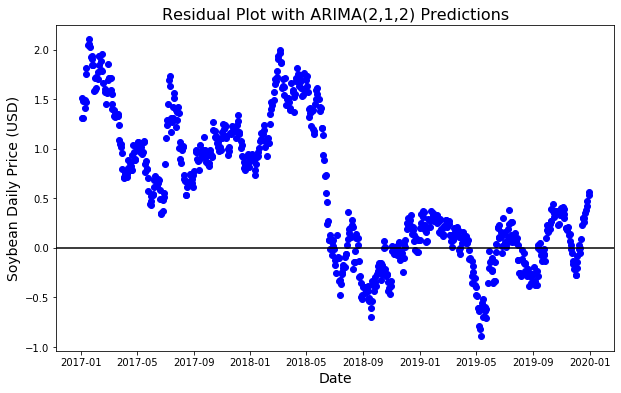

In [127]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(resid_trial, 'bo', color = 'blue')
plt.ylabel('Soybean Daily Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title(label = 'Residual Plot with ARIMA(2,1,2) Predictions', fontsize=16)
plt.axhline(0, color = 'k', ls = '-')
plt.show();

In [53]:
model_sm = sm.tsa.statespace.SARIMAX(endog = train_trial.astype(float).dropna(),order = (2,1,2), seasonal_order = (0,0,0,365))
sarima_trial = model_sm.fit()
forecast_sm_trial = sarima_trial.forecast(len(test_trial), step=1, alpha = 0.05)
print(f'MAE = {mean_absolute_error(test_trial, forecast_sm_trial)}')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MAE = 0.7800903501743822


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [54]:
model_sm = sm.tsa.statespace.SARIMAX(endog = train_trial.astype(float).dropna(),order = (2,1,2), seasonal_order = (1,0,0,365))
sarima_trial = model_sm.fit()
forecast_sm_trial = sarima_trial.forecast(len(test_trial), step=1, alpha = 0.05)
print(f'MAE = {mean_absolute_error(test_trial, forecast_sm_trial)}')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


MAE = 0.7712687629445979


In [126]:
model_sm = sm.tsa.statespace.SARIMAX(endog = train_trial.astype(float).dropna(),order = (2,1,2), seasonal_order = (2,0,0,365))
sarima_trial = model_sm.fit()
forecast_sm_trial = sarima_trial.forecast(len(test_trial), step=1, alpha = 0.05)
print(f'MAE = {mean_absolute_error(test_trial, forecast_sm_trial)}')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

In [225]:
model_sm = sm.tsa.statespace.SARIMAX(endog = train_trial.astype(float).dropna(),order = (2,1,2), seasonal_order = (1,0,2,30))
sarima_trial = model_sm.fit()
forecast_sm_trial = sarima_trial.forecast(len(test_trial), step=1, alpha = 0.05)
print(f'MAE = {mean_absolute_error(test_trial, forecast_sm_trial)}')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MAE = 0.7767637668305256


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [226]:
model_sm = sm.tsa.statespace.SARIMAX(endog = train_trial.astype(float).dropna(),order = (2,1,2), seasonal_order = (2,0,2,30))
sarima_trial = model_sm.fit()
forecast_sm_trial = sarima_trial.forecast(len(test_trial), step=1, alpha = 0.05)
print(f'MAE = {mean_absolute_error(test_trial, forecast_sm_trial)}')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MAE = 0.773880167767164


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [227]:
model_sm = sm.tsa.statespace.SARIMAX(endog = train_trial.astype(float).dropna(),order = (2,1,2), seasonal_order = (1,1,1,30))
sarima_trial = model_sm.fit()
forecast_sm_trial = sarima_trial.forecast(len(test_trial), step=1, alpha = 0.05)
print(f'MAE = {mean_absolute_error(test_trial, forecast_sm_trial)}')

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MAE = 0.6871380018572696


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


failed to converge when seasonal component was 1 so no differencing!


In [128]:
360/30

12.0

In [ ]:

best_mae = 99 * (10 ** 16)
best_P = 0
best_Q = 0
best_D = 0
best_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,360,30)
                try:        
                    print(f'Attempting to fit SARIMA(2, 1, 2) model with seasonal ({P},{D},{Q},{S}).')
                    # Instantiate SARIMAX model
                    sarima = sm.tsa.statespace.SARIMAX(endog = train.astype(float).dropna(),
                                                       order = (2,1,2), 
                                                       seasonal_order = (P,D,Q,S)#,
                                                      #exog = X_train['precip_lag_1'].dropna()
                                                      )

                    # Fit SARIMA model.
                    model = sarima.fit()
                    
                    #Generate predictions based on test set
                    forecasts = model.forecast(len(test), step=1, alpha = 0.05)
                    
                    #Evaluate predictions
                    print(f'The MAE for (2,1,2)x({P},{D},{Q},{S}) is {mean_absolute_error(test_trial, forecast)}')
                    
                    # Is my current model's MAE better than our best_mae?
                    if best_mae>mean_absolute_error(test_trial, forecast):
                        # If so, let's overwrite best_aic, best_p, and best_q.
                        best_mae = mean_absolute_error(test_trial, forecast)
                        best_P = P
                        best_D = D
                        best_Q = Q
                        best_S = S
            
                except:
                    pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes MAE is the SARIMA(2,1,2)*({best_P},{best_D},{best_Q},{best_S}).')
print(f'This model has an MAE of {best_mae}.')

Attempting to fit SARIMA(2, 1, 2) model with seasonal (0,0,0,365).


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The AIC for SARIMA(2,1,2)*(0,0,0,365) is: -7109.6296262535725
Attempting to fit SARIMA(2, 1, 2) model with seasonal (0,0,1,365).


/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [174]:
train_ex = data[data.index<'2016-01-01'].drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN']).dropna()
test_ex = data[data.index>='2016-01-01'].drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN']).dropna()


In [175]:
train_ex

,Settlement Price,IA_prcp_lag_1,IL_prcp_lag_1,MN_prcp_lag_1,IA_TMIN_lag_1,IL_TMIN_lag_1,MN_TMIN_lag_1,IA_TMIN_lag_360,IL_TMIN_lag_360,MN_TMIN_lag_360,IA_TMAX_lag_1,IL_TMAX_lag_1,MN_TMAX_lag_1,IA_TMAX_lag_360,IL_TMAX_lag_360,MN_TMAX_lag_360
DATE,,,,,,,,,,,,,,,,
1991-06-05,5.805,0.16,0.00,0.22,61.0,68.0,57.0,28.0,25.0,1.0,80.0,91.0,81.0,49.0,45.0,27.0
1991-06-06,5.805,0.00,0.00,0.58,58.0,60.0,55.0,35.0,32.0,19.0,76.0,86.0,64.0,45.0,49.0,32.0
1991-06-07,5.835,0.00,0.00,0.00,51.0,51.0,56.0,21.0,32.0,1.0,76.0,79.0,72.0,42.0,47.0,26.0
1991-06-10,5.725,0.00,0.00,0.00,51.0,49.0,58.0,18.0,16.0,11.0,78.0,83.0,77.0,40.0,38.0,20.0
1991-06-11,5.733,0.00,0.00,0.44,65.0,51.0,60.0,31.0,21.0,16.0,82.0,89.0,82.0,43.0,50.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,8.730,0.17,1.39,0.00,29.0,48.0,21.0,65.0,70.0,56.0,46.0,64.0,33.0,91.0,88.0,77.0
2015-12-28,8.613,0.14,0.00,0.00,29.0,32.0,16.0,55.0,53.0,57.0,56.0,60.0,29.0,79.0,84.0,79.0
2015-12-29,8.658,0.53,2.46,0.00,27.0,40.0,-7.0,58.0,55.0,59.0,32.0,50.0,3.0,78.0,81.0,78.0


In [167]:
data

,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,Settlement Price,...,MN_TMIN_lag_1,IA_TMIN_lag_360,IL_TMIN_lag_360,MN_TMIN_lag_360,IA_TMAX_lag_1,IL_TMAX_lag_1,MN_TMAX_lag_1,IA_TMAX_lag_360,IL_TMAX_lag_360,MN_TMAX_lag_360
DATE,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.00,0.00,0.00,49.0,45.0,27.0,28.0,25.0,1.0,5.613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.00,0.00,0.00,45.0,49.0,32.0,35.0,32.0,19.0,5.673,...,1.0,NaN,NaN,NaN,49.0,45.0,27.0,NaN,NaN,NaN
1990-01-04,0.94,0.05,0.00,42.0,47.0,26.0,21.0,32.0,1.0,5.633,...,19.0,NaN,NaN,NaN,45.0,49.0,32.0,NaN,NaN,NaN
1990-01-05,0.00,0.00,0.00,40.0,38.0,20.0,18.0,16.0,11.0,5.645,...,1.0,NaN,NaN,NaN,42.0,47.0,26.0,NaN,NaN,NaN
1990-01-08,0.00,0.00,0.00,43.0,50.0,40.0,31.0,21.0,16.0,5.707,...,11.0,NaN,NaN,NaN,40.0,38.0,20.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.00,0.00,0.00,53.0,57.0,32.0,27.0,26.0,22.0,9.365,...,19.0,67.0,67.0,62.0,45.0,56.0,35.0,86.0,96.0,68.0
2019-12-26,0.00,0.01,0.01,62.0,68.0,33.0,32.0,46.0,22.0,9.465,...,22.0,62.0,68.0,63.0,53.0,57.0,32.0,78.0,86.0,80.0
2019-12-27,0.00,0.00,0.02,37.0,48.0,25.0,32.0,39.0,20.0,9.415,...,22.0,65.0,60.0,58.0,62.0,68.0,33.0,84.0,89.0,79.0


In [ ]:
X_train['precip_lag_1'] = X_train['total_precip'].shift(1)

In [154]:
test

,Settlement Price
Date,
2017-01-03,9.950
2017-01-04,10.153
2017-01-05,10.125
2017-01-06,9.948
2017-01-09,10.052
...,...
2019-12-24,9.365
2019-12-26,9.465
2019-12-27,9.415


In [ ]:
# Convert training/ testing sets to a DataFrame.
X_train = pd.DataFrame(train_ex)
X_test = pd.DataFrame(test_ex)

# Add column for lagged values of precipitation.
X_train['precip_lag_1'] = X_train.shift(1)
X_test.shift(1)

#Check out top of the test dataframe
X_test[['precip_lag_1']].head()

In [179]:
train_ex.drop(columns=['Settlement Price'])

,IA_prcp_lag_1,IL_prcp_lag_1,MN_prcp_lag_1,IA_TMIN_lag_1,IL_TMIN_lag_1,MN_TMIN_lag_1,IA_TMIN_lag_360,IL_TMIN_lag_360,MN_TMIN_lag_360,IA_TMAX_lag_1,IL_TMAX_lag_1,MN_TMAX_lag_1,IA_TMAX_lag_360,IL_TMAX_lag_360,MN_TMAX_lag_360
DATE,,,,,,,,,,,,,,,
1991-06-05,0.16,0.00,0.22,61.0,68.0,57.0,28.0,25.0,1.0,80.0,91.0,81.0,49.0,45.0,27.0
1991-06-06,0.00,0.00,0.58,58.0,60.0,55.0,35.0,32.0,19.0,76.0,86.0,64.0,45.0,49.0,32.0
1991-06-07,0.00,0.00,0.00,51.0,51.0,56.0,21.0,32.0,1.0,76.0,79.0,72.0,42.0,47.0,26.0
1991-06-10,0.00,0.00,0.00,51.0,49.0,58.0,18.0,16.0,11.0,78.0,83.0,77.0,40.0,38.0,20.0
1991-06-11,0.00,0.00,0.44,65.0,51.0,60.0,31.0,21.0,16.0,82.0,89.0,82.0,43.0,50.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.17,1.39,0.00,29.0,48.0,21.0,65.0,70.0,56.0,46.0,64.0,33.0,91.0,88.0,77.0
2015-12-28,0.14,0.00,0.00,29.0,32.0,16.0,55.0,53.0,57.0,56.0,60.0,29.0,79.0,84.0,79.0
2015-12-29,0.53,2.46,0.00,27.0,40.0,-7.0,58.0,55.0,59.0,32.0,50.0,3.0,78.0,81.0,78.0


In [185]:
sarimax = SARIMAX(endog = train_ex['Settlement Price'],
                order = (2,1,2),
                 seasonal_order = (1,0,0,365),
                 exog = train_ex.drop(columns=['Settlement Price']))

#fit SARIMAX model
model = sarimax.fit()

/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/andreayoss/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

In [ ]:
#Generate predictions based on test set
#preds = model.predict(start = datetime(2017,1,1),
                   #  end = test_ex.index[-1],
                   #  exog = test_ex.drop(columns=['Settlement Price']))

preds = model.forecast(len(test_ex), 
               exog = test_ex.drop(columns = ['Settlement Price']),
               step=1, 
               alpha = 0.05)
        
#evaluate predictions
print(mean_absolute_error(test_ex['Settlement Price'], preds))


In [ ]:
#plot data
plt.figure(figsize = (10,6))
plt.plot(train_ex['Settlement Price'], color = 'blue')
plt.plot(test_ex['Settlement Price'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Av Daily Soybean Price with SARIMAX(2,1,2)X(0,0,0,365)')
plt.show();